In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, MeanShift
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from langdetect import detect
from langdetect import DetectorFactory
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from string import digits
import seaborn as sns
import os
import re
import sys
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import matplotlib 
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [ ]:
# To Load Processed DataFrame
df = pd.read_pickle(".\\Models\\dataframe_processed.pkl")

In [2]:
#Load data
data_frame = pd.read_pickle(".\\Models\\dataframe.pkl")
data_frame = shuffle(data_frame, random_state = 42)
data_frame = data_frame.reset_index(drop=True)
df = data_frame
df

,Title,Abstract,Text
0,Development and Characterization of an Equine ...,We developed a replication-defective reporter ...,The ability of lentiviruses to continually evo...
1,Escape from Autologous Neutralizing Antibodies...,One aim for an HIV vaccine is to elicit neutra...,The current AIDS pandemic is the result of gen...
2,,,The phenomenon of viral interference was first...
3,Tourism crises and island destinations: Experi...,Crisis management and tourism is attracting in...,"Since the late 1990s, the tourism industry in ..."
4,Pathogen and Particle Associations in Wastewat...,Disinfection guidelines exist for pathogen ina...,Although water is abundant and covers 75% of t...
...,...,...,...
33340,Molecular characterisation of Toll-like recept...,Bats are believed to be reservoir hosts for a ...,Bats belong to the order Chiroptera which is d...
33341,DNA Aptamers in the Diagnosis and Treatment of...,Aptamers have a promising role in the field of...,Aptamers can be broadly defined as short biomo...
33342,A Likelihood Based Method for Real Time Estima...,We present a method for the simultaneous estim...,Infectious diseases seem to be an endemic cond...
33343,EPS8 facilitates uncoating of influenza A virus,All viruses balance interactions between cellu...,Attachment and entry into a host cell is the f...


In [35]:
# If Crashed load pickles
k = 25
model = pickle.load(open('.\\Models\\k_{}.p'.format(k), 'rb') )
X_transformed = pickle.load(open(".\\Models\\k_{}_T-SNE.p".format(k), 'rb') )
labels = pickle.load(open(".\\Models\\k_{}_lables.p".format(k), 'rb'))
CSV_PATH = "E:\\Projects\\COVID-19-Research\\CORD-19-Cluster\\Output"
file = open(os.path.join(CSV_PATH, 'Key_words.txt'), "r", encoding='utf8') 
file = file.read()
all_keywords = []

for words in file.split(". "):
    aa = []
    for word in words.split(" "):
        aa.append(word)
    all_keywords.append(aa)

In [ ]:
PATH = "E:\\Projects\\COVID-19-Research\\CORD-19-Cluster\\CORD-19-Research-Challenge"
data_one_doc = ""
data = []
num = 1

for i in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, i)):
        print('Scanning Dir {}'.format(i))
        for ii in os.listdir(os.path.join(PATH, i)):
            for iii in tqdm(os.listdir(os.path.join(PATH, i, ii))):
                df = json.load(open(os.path.join(PATH, i, ii, iii), 'r'))
                title = df['metadata']['title']
                try:
                    abstract = df['abstract'][0]
                    abstract = abstract['text']
                except:
                    abstract = ""
                for text in df['body_text']:
                    data_one_doc += (text['text'])
                data.append([title, abstract, data_one_doc])
                data_one_doc = ""
                #num  += 1
                #if num  > 20000:
                    #break


In [ ]:
data_frame = pd.DataFrame(data = data, columns = ['Title','Abstract','Text'])
data_frame.to_pickle(".\\Models\\dataframe.pkl")
data_frame = shuffle(data_frame, random_state = 42)
data_frame = data_frame.reset_index(drop=True)
df = data_frame
#df

In [4]:
# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['Text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['Abstract'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33345/33345 [04:24<00:00, 126.11it/s]


In [5]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
#print("Total: {}\n".format(len(languages)))
print(languages_dict)

{'so': 2, 'es': 276, 'ru': 2, 'et': 3, 'no': 1, 'unknown': 7, 'nl': 1, 'tl': 3, 'da': 2, 'lt': 3, 'zh-cn': 1, 'ca': 4, 'ro': 1, 'en': 32591, 'fr': 327, 'af': 2, 'cy': 4, 'it': 14, 'hu': 2, 'pl': 3, 'id': 2, 'sv': 1, 'de': 71, 'ko': 6, 'pt': 16}


In [6]:
df['language'] = languages
df = df[df['language'] == 'en'] 

print('# of eng docs after removal of lang: {}'.format(len(df)))

# of eng docs after removal of lang: 32591


In [7]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.',',', '.', '*', 'https', ':', '/', '=', '>', '<', 'doi', 'preprint', 'copyright', 'peer', 'reviewed',
    'al.', 'Elsevier', 'PMC', 'CZI', 'aa', 'abs', 'ab'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [8]:
def process_text(data):
    processed_text = []
    for text in data:
        #pro_text = []
        pro_words = []
        dat = []
        for word in text.lower().split(" "):
            if word not in stopwords:
                pro_words.append(word) 
        remove_digits = str.maketrans('', '', digits)
        #for k in pro_words:
         #   if not k.isdigit():
          #      dat.append(k)
        #dat = ' '.join(k for k in dat)
        dat = ' '.join(k for k in pro_words)
        dat = dat.translate(remove_digits)
        dat = re.sub("[\(\[].*?[\)\]]", "", dat)
        dat = re.sub('[^a-zA-z0-9\s]','',dat)
        #pro_text.append(dat)
        processed_text.append(dat)
    return processed_text

In [33]:
processed_text = process_text(df["Text"])
df["processed_text"] = processed_text
print(len(processed_text))

32591


In [34]:
df.to_pickle(".\\Models\\dataframe_processed.pkl")

In [ ]:
#df['processed_text'][0]

In [ ]:
def process_words(text_pre):
    words_processed = []
    for i in [text_pre]:
        dat_word = []
        for text in i:
            for words in text.split(" "):        
                dat_word.append(words)

        words_processed.append(dat_word)

    words_pre = []
    for k in words_processed:
        dat_word = []
        for kk in k:
            if kk != "":
                dat_word.append(kk)
        words_pre.append(dat_word)  
    return words_pre

words_processed = process_words(processed_text)

In [ ]:
print(words_processed[0][:10])

In [ ]:
def vectorize(data):
    vectorizer = TfidfVectorizer(max_features=2**12, stop_words='english')
    X = vectorizer.fit_transform(data)
    return X

In [ ]:
X = vectorize(processed_text)
print(X.shape)

In [ ]:
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X.toarray())
print(X_pca.shape)

In [ ]:
k = 25
kmeans = KMeans(n_clusters=k, random_state=42, n_init=15)
model = kmeans.fit(X_pca)
labels = model.predict(X_pca)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity = 100)
X_transformed = tsne.fit_transform(X_pca)

In [ ]:
pickle.dump(model, open(".\\Models\\k_{}.p".format(k), "wb" ))

# save the final t-SNE
pickle.dump(X_transformed, open(".\\Models\\k_{}_T-SNE.p".format(k), "wb" ))

# save the labels generate with k-means(20)
pickle.dump(labels, open(".\\Models\\k_{}_lables.p".format(k), "wb" ))

In [36]:
def plot_kmeans():
    global k, X_transformed
    # sns settings
    sns.set(rc={'figure.figsize':(12,12), 'axes.facecolor':'white'})

    # colors
    palette = sns.hls_palette(k, l=.4, s=.9)

    # plot
    sns.scatterplot(X_transformed[:,0], X_transformed[:,1], hue=labels, legend='full', palette=palette)
    plt.title("COVID-19 Documents Clustering")
    #plt.savefig("Cluster.svg")
    plt.show()

#plot_kmeans()

In [37]:
def plot_cluster(cluster):
    global k
    if cluster == 25:
        plot_kmeans()
    else:
        sn = []
        sn_labels = []
        for i, ii in enumerate(labels):
            if ii == cluster:
                sn.append([X_transformed[i, 0], X_transformed[i, 1]])
                sn_labels.append(ii)
        sn = np.array(sn)
        sn_labels = np.array(sn_labels)
        # sns settings
        sns.set(rc={'figure.figsize':(12,12), 'axes.facecolor':'white'})

        # colors
        palette = sns.hls_palette(k, l=.4, s=.9)

        # plot
        sns.scatterplot(sn[:,0], sn[:,1], hue=sn_labels, legend='full', palette=[palette[cluster]])
        plt.title("Cluster {}".format(cluster))
        
        #plt.show()

In [38]:
interact(plot_cluster, cluster= widgets.IntSlider(min=0, max=k, step=1, value=25, description='Cluster'))

interactive(children=(IntSlider(value=25, description='Cluster', max=25), Output()), _dom_classes=('widget-int…

<function __main__.plot_cluster(cluster)>

In [31]:
df['Cluster'] = labels
df

,Title,Abstract,Text,language,processed_text,Cluster
0,Development and Characterization of an Equine ...,We developed a replication-defective reporter ...,The ability of lentiviruses to continually evo...,en,ability lentiviruses continually evolve escape...,22
1,Escape from Autologous Neutralizing Antibodies...,One aim for an HIV vaccine is to elicit neutra...,The current AIDS pandemic is the result of gen...,en,current aids pandemic result genetically diver...,9
2,,,The phenomenon of viral interference was first...,en,phenomenon viral interference described nearly...,19
3,Tourism crises and island destinations: Experi...,Crisis management and tourism is attracting in...,"Since the late 1990s, the tourism industry in ...",en,late s tourism industry south east asian regio...,1
4,Pathogen and Particle Associations in Wastewat...,Disinfection guidelines exist for pathogen ina...,Although water is abundant and covers 75% of t...,en,water abundant covers earths surface freshwat...,1
...,...,...,...,...,...,...
33340,Molecular characterisation of Toll-like recept...,Bats are believed to be reservoir hosts for a ...,Bats belong to the order Chiroptera which is d...,en,bats belong order chiroptera divided suborders...,0
33341,DNA Aptamers in the Diagnosis and Treatment of...,Aptamers have a promising role in the field of...,Aptamers can be broadly defined as short biomo...,en,aptamers broadly defined short biomolecules li...,1
33342,A Likelihood Based Method for Real Time Estima...,We present a method for the simultaneous estim...,Infectious diseases seem to be an endemic cond...,en,infectious diseases endemic condition world em...,16
33343,EPS8 facilitates uncoating of influenza A virus,All viruses balance interactions between cellu...,Attachment and entry into a host cell is the f...,en,attachment entry host cell bottleneck virions ...,22


In [14]:
vectorizers = []
    
for ii in range(0, k):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [15]:
def vectorize(labels, vectorizers, k =25):
    vector_text = []
    for i in range(k):
        cluster = np.where(labels == i)
        df_predict = []
        for ii in cluster[0]:
            text = df["processed_text"].iloc[ii]
            df_predict.append(text)
        vector_text.append([i, df_predict])

    vector_text = dict(vector_text)
    vectorized_data = []
    for i, vectorizer in enumerate(vectorizers):
        vectorized_data.append(vectorizer.fit_transform(vector_text[i]))
    return vectorized_data

vectorized_data = vectorize(labels, vectorizers, k)

In [16]:
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []

for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)    

In [17]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19
Current Cluster: 20
Current Cluster: 21
Current Cluster: 22
Current Cluster: 23
Current Cluster: 24


In [18]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [19]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19
Current Cluster: 20
Current Cluster: 21
Current Cluster: 22
Current Cluster: 23
Current Cluster: 24


In [20]:
def keysum(cluster):
    key_sum = ''
    for i in all_keywords[cluster]:
        key_sum += i + ", "

    return print(key_sum)

interact(keysum, cluster= widgets.IntSlider(min=0, max=k-1, step=1, value=0, description = 'Cluster: '))

interactive(children=(IntSlider(value=0, description='Cluster: ', max=24), Output()), _dom_classes=('widget-in…

<function __main__.keysum(cluster)>

In [21]:
def plot_points(point, key_word):
    global k, df_sum
    sn = []
    sn_labels = []
    for i, ii in enumerate(point):
        sn.append([X_transformed[ii, 0], X_transformed[ii, 1]])
        sn_labels.append(df['Cluster'].iloc[ii])
    sn = np.array(sn)
    sn_labels = np.array(sn_labels)
    k_1 = len(set(sn_labels))
    #print(sn)
    
    #cluster = df['Cluster'].loc[point]
    
    # sns settings
    sns.set(rc={'figure.figsize':(12,12), 'axes.facecolor':'white'})

    # colors
    palette = sns.hls_palette(k_1, l=.4, s=.9)

    # plot
    sns.scatterplot(sn[:, 0], sn[:, 1], hue=sn_labels, legend='full', palette= palette)
    plt.title("Points for {}".format(key_word))
    #plt.show()

In [22]:
def summary(key_word):
    loc = []
    df_sum = []
    global df
    abs_sum = ''
    abstract = process_text(df['Abstract'])
    titles = process_text(df['Title'])
    for idx, abst in enumerate(abstract): 
        for words in abst.split(" "):
            if words == key_word:
                loc.append(idx)
                abs_sum += abst + ". "
    for idx, abst in enumerate(titles):    
        for words in abst.split(" "):
            if words == key_word:
                loc.append(idx)
            
    loc = set(loc) 
    
    for i in loc:
        df_sum.append(df.iloc[i])
    
    df_sum = pd.DataFrame(data = df_sum)
    df_sum = df_sum.reset_index(drop = True)
    df_sum.drop(['Text', 'language'], axis=1,inplace=True)
    plot_points(loc, key_word)
    
    return abs_sum, loc, df_sum
        

In [23]:
key_word = widgets.Text(value='virus',
    placeholder='Type something',
    description='Key Word',
    disabled=False)
key_word

Text(value='virus', description='Key Word', placeholder='Type something')

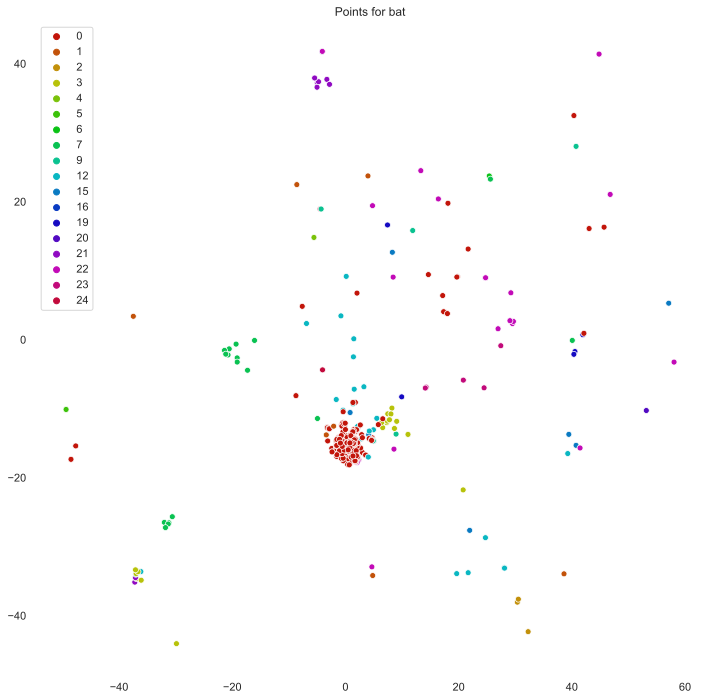

In [27]:
abstract_summary, loc, df_sum = summary(key_word.value)

In [28]:
df_sum

,Title,Abstract,processed_text,Cluster
0,Evidence for widespread infection of African b...,hemorrhagic fever in humans. The geographic ra...,bats represent migratory flying mammals bats ...,0
1,Coronavirus and paramyxovirus in bats from Nor...,Background: Bat-borne virus surveillance is ne...,bats represent onefifth existing mammals cons...,0
2,Microbiome analysis reveals the abundance of b...,Bats are crucial for proper functioning of an ...,previous reports bacterial identification bat ...,0
3,Henipavirus Neutralising Antibodies in an Isol...,Isolated islands provide valuable opportunitie...,reservoir host population size density play cr...,0
4,Discovery of a Novel Bat Gammaherpesvirus,Zoonosis is the leading cause of emerging infe...,threat rise term eid refers large range patho...,0
...,...,...,...,...
371,viruses Characterization of a New Member of Al...,Bats have been identified as a natural reservo...,members coronaviridae family enveloped nonsegm...,12
372,Bat origin of human coronaviruses,Bats have been recognized as the natural reser...,bats extensive geographical distribution capab...,0
373,Discovery and Characterization of Novel Bat Co...,Coronaviruses are positive-stranded RNA viruse...,bats mammals order chiroptera possess range un...,0
374,Bacterial diversity of bat guano from Cabalyor...,Bats are highly diverse and ecologically valua...,introduction bats highly diverse ecologically...,0


In [ ]:
#from gensim.summarization.summarizer import summarize
#summ_words = summarize(abstract_summary, word_count = 1000)

In [ ]:
#summ_words

In [30]:
# Saving CSV Files and summary
CSV_PATH = "E:\\Projects\\COVID-19-Research\\CORD-19-Cluster\\Output"
df_sum.to_csv(os.path.join(CSV_PATH, 'Summary_Docs.csv'), index = False, header=True)
#file = open(os.path.join(CSV_PATH, 'Summary.txt'), "w", encoding='utf8') 
#file.write(summ_words)

all_key_w = ""
for i in all_keywords:
    for ii in i:
        all_key_w += ii + " "
    all_key_w += ". "

file = open(os.path.join(CSV_PATH, 'Key_words.txt'), "w", encoding='utf8') 
file.write(all_key_w)

7798